In [23]:
from ScriptFiles import DataCleaning_and_Prediction as dc
from ScriptFiles import DataRead_and_PreClean as dr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
 

In [24]:
#############################################################################
### Function to plot Data profile in terms of fuelvoltage, Distance over time

def plotData_profiles(df):
    plt.rcParams['figure.figsize'] = [16, 12]

    #### 1. Checking order of Data, as per datetime
    plt.subplot(3,1,1)
    plt.plot(df.index, df.datetime, 'g.', markersize=1, linewidth=1);

    plt.subplot(3,1,2)
    plt.plot(df.index, df.fuelVoltage, 'g.', markersize=2, linewidth=1);

    plt.subplot(3,1,3)
    plt.plot(df.index, df.distance, 'g-', markersize=2, linewidth=1);
    plt.title("Cumulative Distance vs Time", fontsize=15)
    plt.show()

In [25]:
#######################################################
### Function to Plot theft Points over Cleaned Data

def plot_theftpts(cleanedDf , theftpts=[], refPts=[], xlim=[], ylim1 = [], ylim2 = []):

    plt.rcParams['figure.figsize'] = [20, 4]
    # plt.subplot(6,1,1)
    fig, ax1 = plt.subplots()
    ax1.plot(cleanedDf.index, cleanedDf.fuelVoltage, 'g.', markersize=2, linewidth=1)
    ax1.set_xlabel('time index')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('FuelVoltage', color='b')
    ax1.tick_params('y', colors='b')
    if len(ylim1)!=0:
        ax1.set_ylim(ylim1)

    ax2 = ax1.twinx()
    ax2.plot(cleanedDf.index, cleanedDf.distance, 'b-', markersize=2, linewidth=1)
    ax2.set_ylabel('Distance', color='b')
    if len(ylim2)!=0:
        ax2.set_ylim(ylim2)
    plt.title("Initial Prediction theft Points - ZOOMED")
    if len(xlim) !=0:
        plt.xlim(xlim)
    
    for pt in theftpts:
        ax1.axvline(pt, color = 'black')
        
    for pt in refPts:
        ax1.axvline(pt, color = 'Red')
    plt.show()


In [69]:
def plot_Results(df, df_clean, result_df, theftpts=[], refPts=[], xlim = [], ylim1 = [], ylim2 = []):

    plt.rcParams['figure.figsize']=[16,12]
    fig, axi = plt.subplots(4, 1)
    axi[0].plot(df.datetime, df.fuelVoltage, 'g.', markersize=1, linewidth=1);
    #plt.plot(df.datetime, df.distance, 'b-', markersize=1, linewidth=1);
    axi[0].set_title('Original FuelData vs Time')
    axi[0].set_xlabel('time')

    axi[1].plot(df_clean.index, df_clean.fuelVoltage, 'g.', markersize=2, linewidth=1)
    axi[1].set_xlabel('time index')
    # Make the y-axis label, ticks and tick labels match the line color.
    axi[1].set_ylabel('FuelVoltage', color='b')
    axi[1].tick_params('y', colors='b')
    if len(ylim1) != 0:
        axi[1].set_ylim(ylim1)

    ax2 = axi[1].twinx()
    ax2.plot(df_clean.index, df_clean.distance, 'b-', markersize=2, linewidth=1)
    ax2.set_ylabel('Distance', color='b')
    if len(ylim2) != 0:
        ax2.set_ylim(ylim2)
    if len(xlim) != 0:
        plt.xlim(xlim)
    axi[1].set_title('Cleaned Data')
    for pt in theftpts:
        axi[1].axvline(pt, color = 'black')
        
    for pt in refPts:
        axi[1].axvline(pt, color = 'Red')
    
    
    
    axi[2].plot(df_clean.index, df_clean.fuelVoltage, 'g.', markersize=2, linewidth=1)
    axi[2].set_xlabel('time index')
    # Make the y-axis label, ticks and tick labels match the line color.
    axi[2].set_ylabel('FuelVoltage', color='b')
    axi[2].tick_params('y', colors='b')
    if len(ylim1)!=0:
        axi[2].set_ylim(ylim1)

    ax2 = axi[2].twinx()
    ax2.plot(df_clean.index, df_clean.distance, 'b-', markersize=2, linewidth=1)
    ax2.set_ylabel('Distance', color='b')
    if len(ylim2)!=0:
        axi[2].set_ylim(ylim2)
        
    if len(xlim) !=0:
        plt.xlim(xlim)
    plt.title('Final Predicted Theft Pts - ZOOMED')

    for pt in result_df.theft_index:
        plt.axvline(pt, color = 'black')
        
    for pt in refPts:
        axi[2].axvline(pt, color = 'Red')

    axi[3].plot(result_df.theft_index, result_df['fuel_PercentJump'], 'g-', markersize=3, linewidth=1);
    axi[3].set_title('Fuel/km Ratio at Predicted theft pts - ZOOMED')
    
    axi[3].set_xlabel('time index')
    
    fig.tight_layout()

#     if len(xlim) !=0:
#         plt.xlim(xlim)
#     if len(ylim)!=0:
#         plt.ylim(ylim)

    #plt.plot(df_clean.index, df_clean.distance, 'b-', markersize=1, linewidth=1);

    plt.show()

Text(0.5,1,'Simple plot')

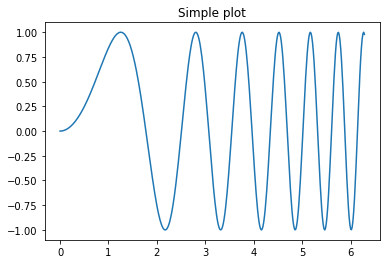

In [27]:
x = np.linspace(0, 2*np.pi, 400)
y = np.sin(x**2)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Simple plot')

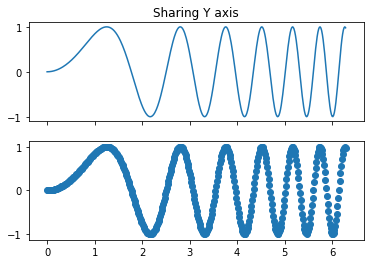

In [28]:
#Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)

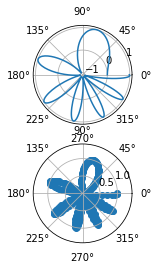

In [29]:
#Creates four polar axes, and accesses them through the returned array

fig, axes = plt.subplots(2, 1, subplot_kw=dict(polar=True))
axes[0].plot(x, y)
axes[1].scatter(x, y)

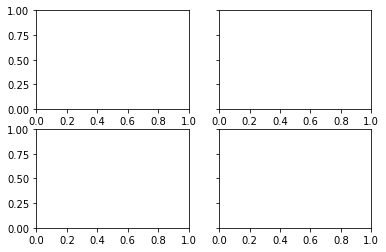

In [30]:
plt.subplots(2, 2, sharey='row');
#Share a Y axis with each row of subplots

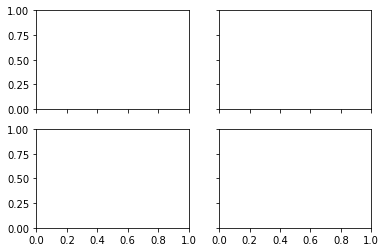

In [31]:
#Share both X and Y axes with all subplots
plt.subplots(2, 2, sharex='all', sharey='all');

In [32]:
#####################################################################
### Function to generate FuelMaxVoltage & FuelMinVoltage, to be sent
### to the main devices database for records.
def Gen_FuelMaxMin(df):
    df = dr.perform_PreFormating(df)
    dff = dr.perform_postFormating(df)

    fmax = dff.fuelVoltage.max()
    fmin = dff.fuelVoltage.min()

    df_clean = dc.Clean_NoiseData(dff, 6, fmax, fmin)

    return df_clean.fuelVoltage.max(), df_clean.fuelVoltage.min()

In [46]:
folderpath = r"G:\Analytics\FuelAnalysis\test2"
savePath = r"G:\Analytics\FuelAnalysis\results"
filepath = r""
fuelMax = 100
df_list, filesname = dr.read__MultipleCSVs(folder_path= folderpath, nfiles=4)
ctr = 0
def formatDf(df):
    #df_list[0].info()
    df = dr.perform_PreFormating(df)
    print ("Dataset_"+str(ctr+1) +" Preformatting Done")

    dff = dr.perform_postFormating(df)
    print("Dataset_" + str(ctr + 1) + " Postformatting Done")
    return dff

def cleanDF(dff, fuelMax, fuelMin):
    df_clean = dc.Clean_NoiseData(dff, 6, fuelMax, fuelMin)
    print("Dataset_" + str(ctr + 1) + " Data Cleaning Done")
    return df_clean

def findtheft(df_clean, fuelMax, fuelMin):
    theft_pts, refpts = dc.jump_point(df_clean, 0.01, fuelMax, fuelMin)
    print("Dataset_" + str(ctr + 1) + " Theft & Refuel points Indentified")
    return theft_pts, refpts

    

G:\Analytics\FuelAnalysis\test2\cordinates_007042639339.csv
G:\Analytics\FuelAnalysis\test2\cordinates_007042640749.csv
G:\Analytics\FuelAnalysis\test2\cordinates_007042641148.csv
G:\Analytics\FuelAnalysis\test2\cordinates_008527948598.csv


In [75]:
#plotData_profiles(df)
df = df_list[1]
df = df[:]
df = df.reset_index(drop= True)
df.st = df.io_state.apply(lambda x: x[1])
dis = df[df.st == '0'].distance.apply(lambda x: int(x))

C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


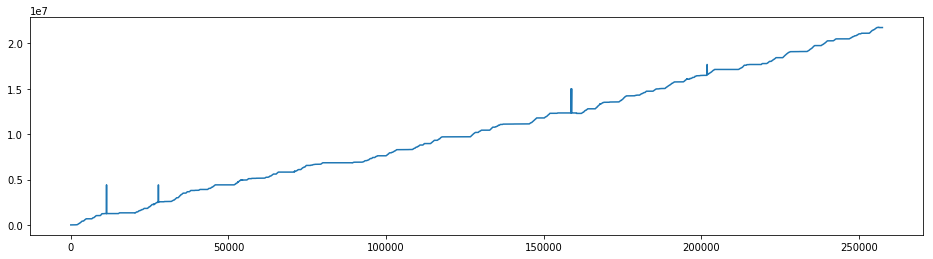

In [48]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(dis)

In [76]:
fuelMax, fuelMin = Gen_FuelMaxMin(df)

In [77]:
dff = formatDf(df.copy())
Dmax = dff.distance.max()

Dataset_1 Preformatting Done
Dataset_1 Postformatting Done


In [78]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12813 entries, 0 to 12812
Data columns (total 7 columns):
datetime       12813 non-null datetime64[ns]
lat            12813 non-null float64
long           12813 non-null float64
speed          12813 non-null float64
distance       12813 non-null float64
fuelVoltage    12813 non-null float64
dev_state      12813 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 700.8 KB


In [79]:
sum(dff[dff.dev_state==0].fuelVoltage <3)

0

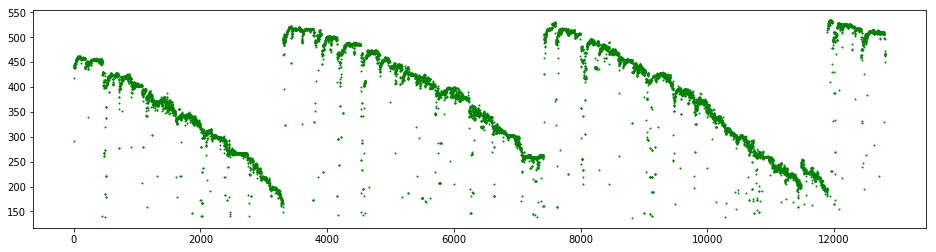

In [92]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(dff.index, dff.fuelVoltage,'g.', markersize = 2);


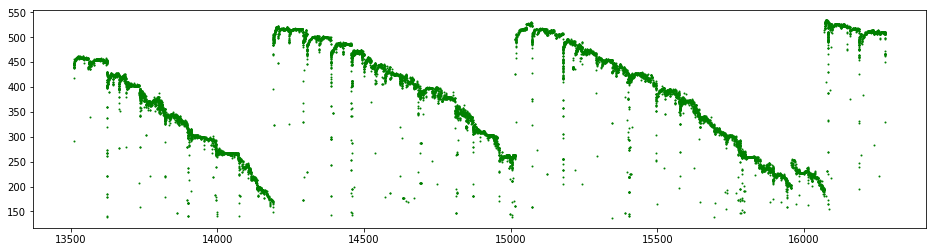

In [93]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(dff.distance*0.001, dff.fuelVoltage, 'g.', markersize = 2)

In [54]:
dff.fuelVoltage.median()

438.0

In [55]:
dff.fuelVoltage.std()

78.52694799625085

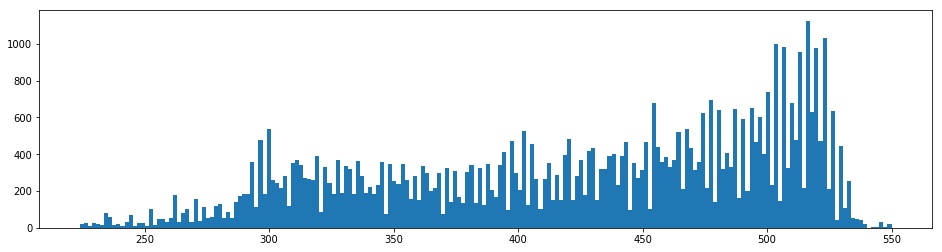

In [56]:
plt.rcParams['figure.figsize'] = [16,4]
plt.hist(dff.fuelVoltage,200);
#plt.xlim(0,0.02)
#plt.ylim(0,2.5)

C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


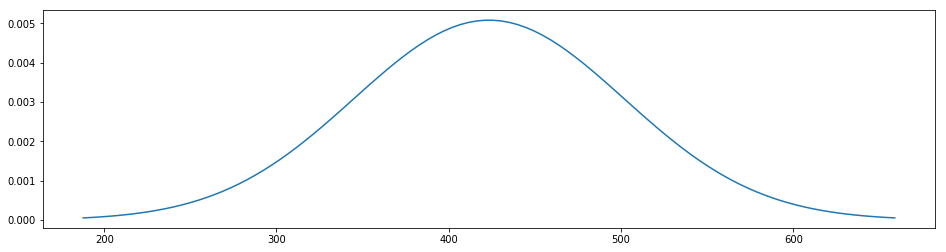

In [57]:
import matplotlib.mlab as mlab
mu = dff.fuelVoltage.mean()
#variance = (dff.fuelVoltage.std())*(dff.fuelVoltage.std())
sigma = dff.fuelVoltage.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))

In [58]:
dff[(dff.fuelVoltage == 0)  & (dff.dev_state == 1)]

,datetime,lat,long,speed,distance,fuelVoltage,dev_state


In [59]:
df_clean = cleanDF(dff.copy(), fuelMax, fuelMin)

Dataset_1 Data Cleaning Done


In [60]:
theft_pts, refpts = findtheft(df_clean, fuelMax, fuelMin)

**
289
Dataset_1 Theft & Refuel points Indentified


In [62]:
refpts

[1168,
 2590,
 3367,
 4320,
 4705,
 5056,
 6553,
 7679,
 8403,
 9788,
 11299,
 12676,
 14062,
 15603,
 16720,
 17764,
 19241,
 20638,
 22525,
 23742,
 25409,
 26817,
 27054,
 28710,
 29564,
 31137,
 32689,
 34778,
 35426]

(7000, 8000)

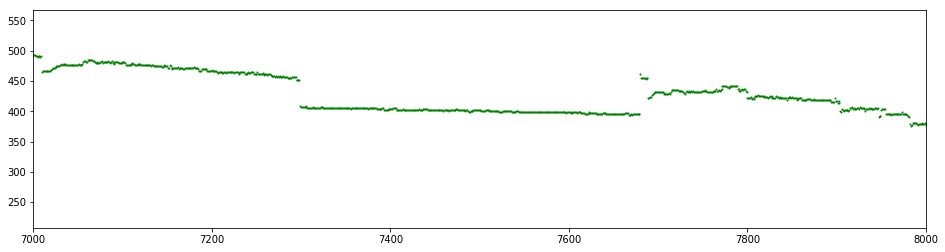

In [63]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(df_clean.index, df_clean.fuelVoltage,'g.', markersize = 2)
plt.xlim(7000,8000)

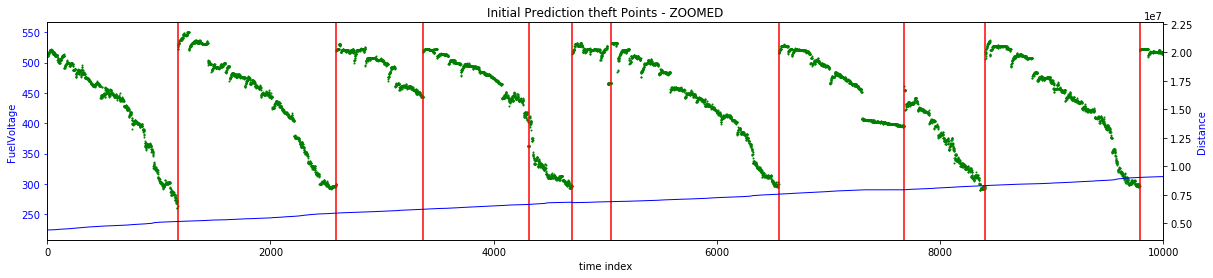

238


In [64]:
xlim = [0,10000]
ylim = []
plot_theftpts(df_clean,refPts=refpts,theftpts=[],  xlim = xlim, ylim1= ylim)
result_df = dc.generate_PredictTable(df_clean,theft_pts,float(1), 1)

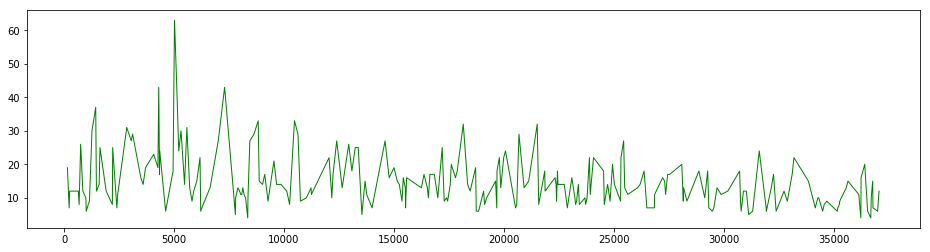

In [67]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(result_df.theft_index, result_df['fuel_PercentJump'], 'g-', markersize=3, linewidth=1);
#plt.ylim(0,400)

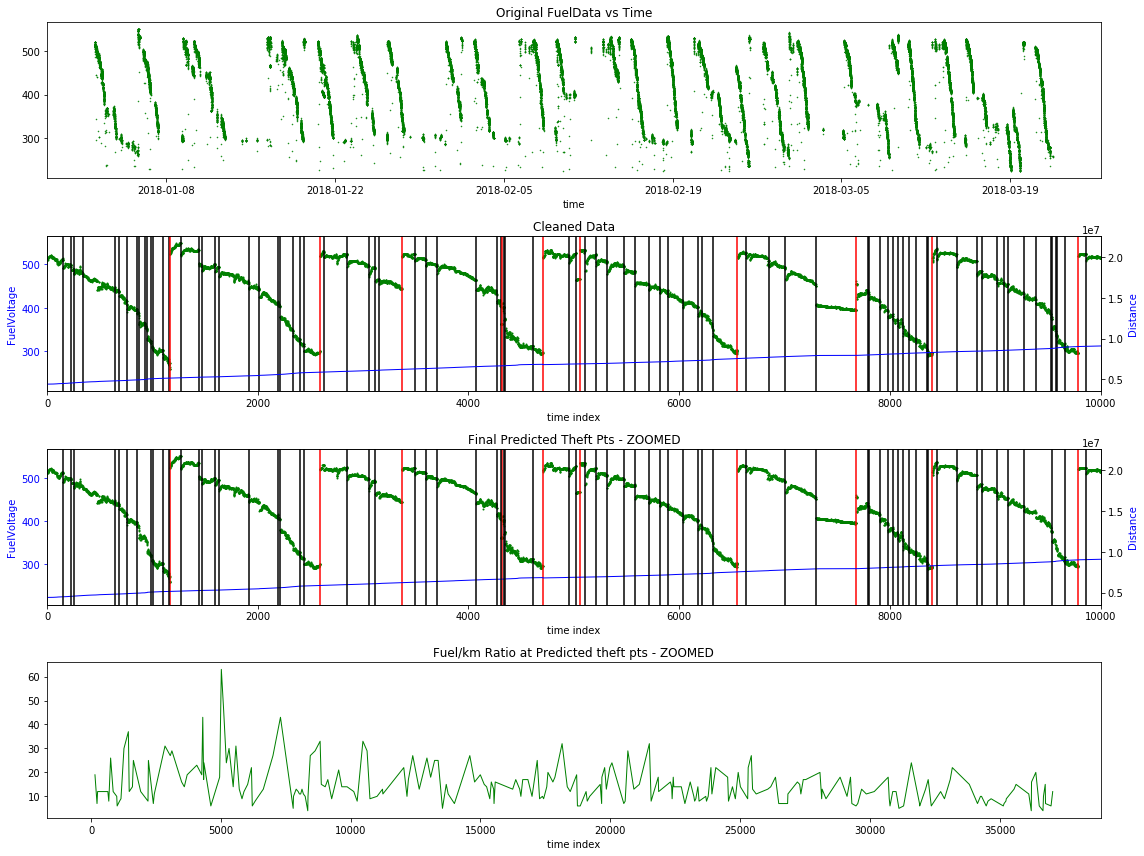

     theft_index        lat       long          theft_time  fuel_PercentJump  dist_jump(KM)       time_jump  Possibility  FuelVoltagePerKM
0            152  24.374520  78.538627 2018-01-02 04:32:27              19.0          3.988 0 days 00:45:56         True          4.764293
1            231  23.896742  78.766580 2018-01-02 06:23:41               7.0          3.475 0 days 00:03:28         True          2.014388
2            253  23.775587  78.809080 2018-01-02 06:44:43              12.0          4.928 0 days 00:20:52         True          2.435065
4            648  22.643562  80.069647 2018-01-02 15:57:20              12.0          1.923 0 days 00:02:30         True          6.240250
5            685  22.622747  80.247662 2018-01-02 16:23:52               8.0          1.617 0 days 00:02:33         True          4.947434
6            755  22.492670  80.518318 2018-01-02 17:45:41              26.0          9.001 0 days 01:26:36         True          2.888568
7            853  22.275203

In [70]:
#build_savePath = savePath + r"\result_dataset_" + filesname[ctr].replace(folderpath,"").replace('\\', "")
#result_df.to_csv(build_savePath)

plot_Results(dff,df_clean, result_df, theft_pts, refpts , xlim = xlim, ylim1=[]);
#ctr+=1
print(result_df)

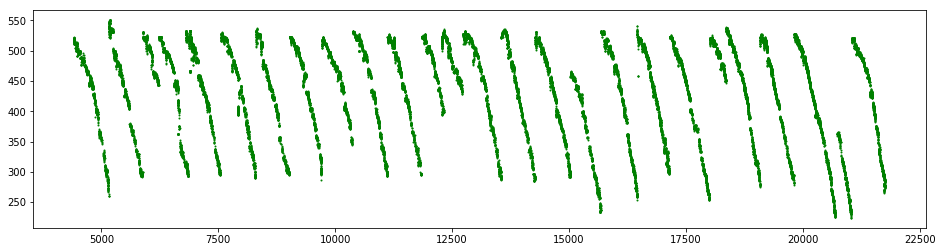

In [73]:
plt.rcParams['figure.figsize'] = [16,4]
plt.plot(df_clean.distance*0.001, df_clean.fuelVoltage, 'g.', markersize = 2)

In [82]:
def findAVG(cleanDf, Dmax):
    i = 0
    ds = 0
    df = 0
    dsRef = 0
    dt = 1000
    avgdt_lst = []
    mean_lst = []
    median_lst = []
    indexlst_lst = []
    ctr = 0
    print(Dmax)
    while dt < 200000:
        avgDT = []
        indexlst = []
        #print (dt)
        i=0
        while i<len(cleanDf): 
            ds = 0
            dsRef = cleanDf.distance[i]
            dfRef = cleanDf.fuelVoltage[i]
            while ((ds)<=dt  and i<len(cleanDf)):
                ds = (cleanDf.distance[i] - dsRef)
                i+=1
                #print(i)

            if i<len(cleanDf):
                df = dfRef- cleanDf.fuelVoltage[i]
                if df>0 :
                    avg = df/ds
                    avgDT.append(avg)
                    indexlst.append(cleanDf.index[i])
            #print(df)
        indexlst_lst.append(indexlst)
        avgdt_lst.append(avgDT)
        med = pd.Series(avgDT).median()
        mean = pd.Series(avgDT).mean()
        #print (med,mean,mode)

        median_lst.append(med)
        mean_lst.append(mean)
        ctr+=1
        dt += 5000
        print (dt)

        
    return [median_lst,mean_lst], avgdt_lst, indexlst_lst

central_DT, avgLst, indexlst = findAVG(df_clean, Dmax)

16277888.0
6000
11000
16000
21000
26000
31000
36000
41000
46000
51000
56000
61000
66000
71000
76000
81000
86000
91000
96000
101000
106000
111000
116000
121000
126000
131000
136000
141000
146000
151000
156000
161000
166000
171000
176000
181000
186000
191000
196000
201000


In [83]:
len(df_clean), len(avgLst), len(indexlst)

(37065, 40, 40)

Text(0.5,1,'Median dF/dS vs Increasing Ds')

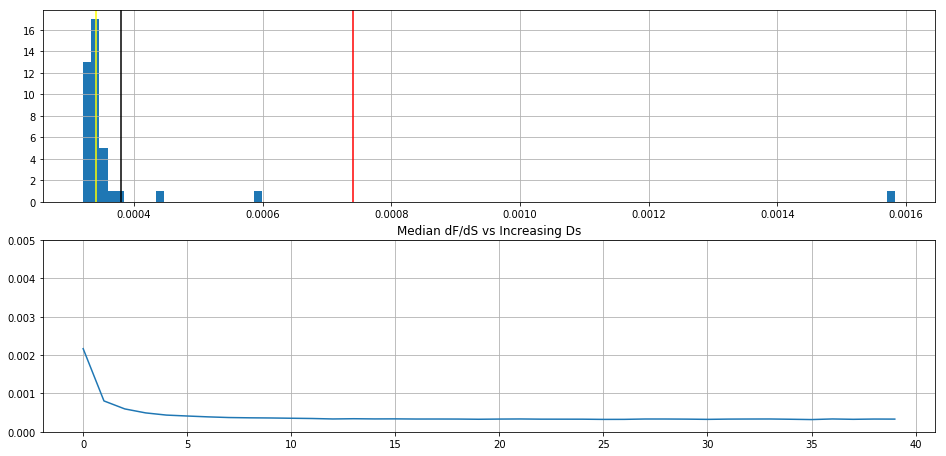

In [85]:
#dt = [i*100 for (i,dt) in zip(len(central_DT[0]),Dmax) ]
plt.rcParams['figure.figsize'] = [16,12]
plt.subplot(3,1,1)
plt.hist(central_DT[0],bins =100);
plt.grid()
plt.axvline(pd.Series(central_DT[0]).mean(), color = 'black')
plt.axvline(pd.Series(central_DT[0]).median(), color = 'yellow')
plt.axvline(pd.Series(central_DT[0]).median() + 2*pd.Series(central_DT[0]).std(), color = 'Red')

#plt.ylim(0,.005)
plt.subplot(3,1,2)
plt.plot(central_DT[1]);
plt.ylim(0,.005)
plt.grid()
plt.title("Median dF/dS vs Increasing Ds")

#plt.plot(central_DT[2]);

        

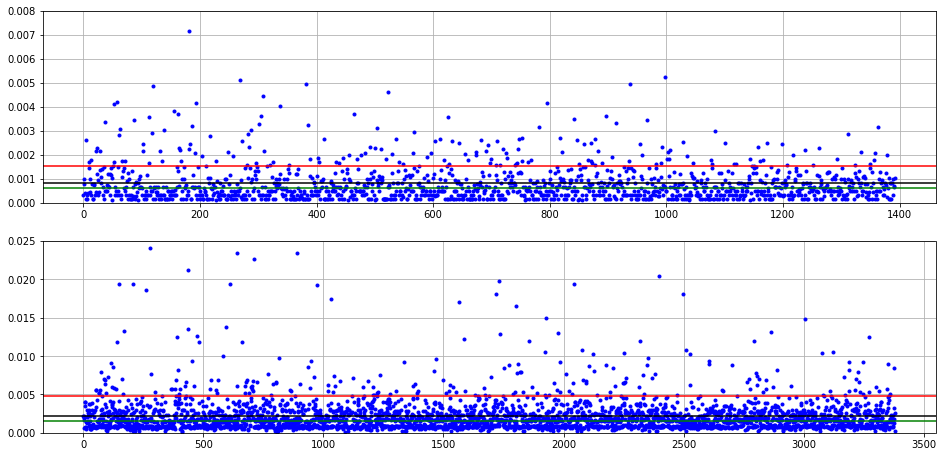

In [86]:
plt.rcParams['figure.figsize'] = [16,12]
plt.subplot(3,1,1)
plt.plot(avgLst[1],'b.');
plt.grid()
plt.ylim(0,.008)

plt.axhline(pd.Series(avgLst[1]).mean(), color = 'black')
plt.axhline(pd.Series(avgLst[1]).median(), color = 'green')
plt.axhline(2*pd.Series(avgLst[1]).std(), color = 'Red')
#plt.xlim(0,500)
plt.subplot(3,1,2)
plt.plot(avgLst[0], 'b.');
plt.axhline(pd.Series(avgLst[0]).mean(), color = 'black')
plt.axhline(pd.Series(avgLst[0]).median(), color = 'green')
plt.axhline(2*pd.Series(avgLst[0]).std(), color = 'Red')

plt.ylim(0,.025)
plt.grid()

In [87]:
(indexlst[0])

[43,
 50,
 62,
 70,
 73,
 93,
 99,
 109,
 150,
 154,
 163,
 178,
 194,
 200,
 217,
 224,
 231,
 233,
 255,
 269,
 277,
 286,
 298,
 305,
 307,
 316,
 318,
 322,
 329,
 332,
 339,
 345,
 350,
 353,
 366,
 373,
 385,
 388,
 395,
 398,
 410,
 414,
 442,
 459,
 467,
 475,
 478,
 492,
 499,
 511,
 515,
 524,
 531,
 545,
 549,
 552,
 556,
 573,
 577,
 590,
 595,
 599,
 606,
 621,
 626,
 644,
 650,
 662,
 677,
 681,
 685,
 687,
 713,
 717,
 729,
 733,
 736,
 743,
 754,
 757,
 765,
 792,
 796,
 805,
 809,
 819,
 829,
 845,
 855,
 864,
 870,
 873,
 886,
 899,
 918,
 926,
 933,
 936,
 944,
 947,
 950,
 952,
 960,
 969,
 981,
 988,
 992,
 994,
 1000,
 1005,
 1009,
 1020,
 1026,
 1044,
 1061,
 1072,
 1081,
 1100,
 1105,
 1112,
 1124,
 1143,
 1147,
 1155,
 1166,
 1207,
 1226,
 1266,
 1271,
 1315,
 1327,
 1340,
 1347,
 1359,
 1375,
 1387,
 1392,
 1439,
 1441,
 1444,
 1449,
 1459,
 1472,
 1499,
 1503,
 1512,
 1534,
 1596,
 1598,
 1633,
 1667,
 1689,
 1698,
 1719,
 1721,
 1725,
 1750,
 1764,
 1772,
 1

In [ ]:
plt.hist(avgLst[1][abs(avgLst[1] - avgLst[1].mean()) < 3*avgLst[1].std()],bins = 200)
plt.axvline(avgLst[1].median(), color = 'black')
plt.axvline(avgLst[1].mean(), color = 'green')

In [89]:
from ipywidgets import *
from IPython.display import display
# w = IntSlider()
# display(w)
def f(x):
    return x
interact(f, x= IntSlider(min=-10, max=30, step=1,value=1));

interactive(children=(IntSlider(value=1, description='x', max=30, min=-10), Output()), _dom_classes=('widget-i…

In [91]:
def f(x):    
    index = indexlst[x]
    avg = avgLst[x]
    plt.rcParams['figure.figsize'] = [16,4]
    plt.plot(index, avg, 'g.', markersize = 2)
    plt.axhline(pd.Series(avg).median(), color = 'red')
    plt.axhline(pd.Series(avg).mean(), color = 'blue')
    plt.axhline(pd.Series(avg).median() + 2*pd.Series(avg).std(), color = 'Black')
    plt.ylim(0,0.002)

interact(f, x= IntSlider(min=0, max=20, step=1,value=10));

interactive(children=(IntSlider(value=10, description='x', max=20), Output()), _dom_classes=('widget-interact'…

In [ ]:
a = avgDT.value_counts()
avgDT.median(), avgDT.mean(), avgDT.mode()

10km:
mean = 0.0167
median = 0.0131
mode = 0.0037

1km:
mean = 0.0095
median = 0.00562
mode = 0.00187

5km:
mean = 0.00138
median = 0.00936
mode = 0.00187

0.5Km
mean = 0.00138
median = 0.00936
mode = 0.00187

50km
mean = 0.0373
median = 0.0365
mode = 0.0411

100km
mean = 0.065988
median = 0.0692
mode = 0.048689









In [ ]:
plt.plot(df_clean.distance * .001*Dmax, df_clean.fuelVoltage,  'g.')